# TME 5 - Logistic Regression & k-fold cross validation

Podlejski & Perrin


In [569]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.datasets import make_blobs
from sklearn.datasets import make_moons
from sklearn import linear_model, datasets
from sklearn.model_selection import KFold
import warnings; warnings.simplefilter('ignore')


path = "../TME1/"

We first generate and plot the actual datasets

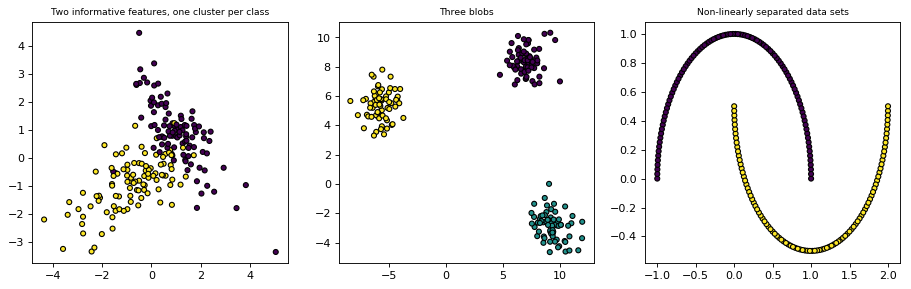

In [590]:
# First simulated data set
plt.figure(figsize=(14,4), dpi=80)
plt.subplot(131)
plt.title("Two informative features, one cluster per class", fontsize='small')
X1, Y1 = make_classification(n_samples=200, n_features=2, n_redundant=0, n_informative=2,n_clusters_per_class=1)
plt.scatter(X1[:, 0], X1[:, 1], marker='o', c=Y1,s=20, edgecolor='k')


# Second simulated data set
plt.subplot(132)
plt.title("Three blobs", fontsize='small')
X2, Y2 = make_blobs(n_samples=200, n_features=2, centers=3)
plt.scatter(X2[:, 0], X2[:, 1], marker='o', c=Y2, s=20, edgecolor='k')


# Third simulated data set
plt.subplot(133)
plt.title("Non-linearly separated data sets", fontsize='small')
X3, Y3 = make_moons(n_samples=200, shuffle=True, noise=None, random_state=None)
plt.scatter(X3[:, 0], X3[:, 1], marker='o', c=Y3, s=20, edgecolor='k')
plt.show()

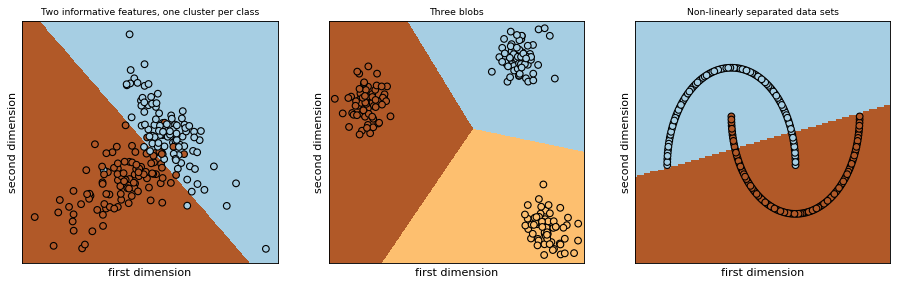

In [591]:
logreg = linear_model.LogisticRegression(C=1e5)

def train_and_plot(X,Y):
    logreg.fit(X, Y)
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = .02  # step size in the mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = logreg.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(1, figsize=(4, 3))
    plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors='k', cmap=plt.cm.Paired)
    plt.xlabel('first dimension')
    plt.ylabel('second dimension')

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())

# First simulated data set
plt.figure(figsize=(14,4), dpi=80)
plt.subplot(131)
plt.title("Two informative features, one cluster per class", fontsize='small')
train_and_plot(X1,Y1)


# Second simulated data set
plt.subplot(132)
plt.title("Three blobs", fontsize='small')
train_and_plot(X2,Y2)

# Third simulated data set
plt.subplot(133)
plt.title("Non-linearly separated data sets", fontsize='small')
train_and_plot(X3,Y3)
plt.show()

In [572]:
def doKFold(X,Y,k):
    kf = KFold(n_splits=k)
    acc = 0
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        logreg.fit(X_train, Y_train)
        acc += logreg.score(X_test,Y_test)
    return acc/k

print("Classification : ", doKFold(X1,Y1,5))
print("Blobs : ", doKFold(X2,Y2,5))
print("Moons : ", doKFold(X3,Y3,5))

Classification :  1.0
Blobs :  1.0
Moons :  0.885


In [578]:
def prob_y_one(theta,x):
    p = np.exp(theta.dot(x.T))
    return p/(1+p)

def prob_y_zero(theta,x):
    return 1 - prob_y_one(theta,x)

def lik(X,Y,theta):
    global n_data
    s = 0
    for i in range(n_data):
        s+= Y[i,0]*theta.dot(X[i].T) - np.log(1+np.exp(theta.dot(X[i].T)))
    return s
        
def grad_lik(X,Y,theta):
    global n_feature 
    global n_data
    grad = np.zeros((1,n_feature))
    pred = np.array([prob_y_one(theta,x) for x in X])
    grad = (Y - pred).T.dot(X)
    return grad

def hess_lik(X,theta):
    global n_feature
    global n_data
    fact = []
    for i in range(n_data):
        p = prob_y_one(theta,X[i])
        fact.append(p*(1-p))
    fact = np.array(fact)
    return -X.T.dot(X*fact)

def binary_grad_descent_newton(X,Y,eps):
    global n_feature 
    global n_data
    Xt = np.array([np.append(x,[1]) for x in X])
    n_feature = Xt.shape[1]
    n_data = Xt.shape[0]
    theta = np.zeros((1,n_feature))
    stop = False
    nit = 0
    l = lik(Xt,Y,theta)
    while not stop:
        grad,hess = grad_lik(Xt,Y,theta),hess_lik(Xt,theta)
        step = np.dot(grad,np.linalg.inv(hess))
        theta = theta - step
        lt = lik(Xt,Y,theta)
        if l - lt <= eps or nit >= 100:
            stop = True
        nit += 1
    return theta[0][0:n_feature-1].T,theta[0][n_feature-1]

def binary_grad_descent(X,Y,eps):
    global n_feature 
    global n_data
    Xt = np.array([np.append(x,[1]) for x in X])
    n_feature = Xt.shape[1]
    n_data = Xt.shape[0]
    theta = np.zeros((1,n_feature))
    stop = False
    nit = 0
    while not stop:
        grad,_ = grad_hess(Xt,Y,theta)
        print(grad)
        theta = theta + grad
        if np.linalg.norm(grad) <= eps or nit >= 100:
            stop = True
        nit += 1
    return theta[0][0:n_feature-1].T,theta[0][n_feature-1]

def multinomial_log_reg(X,Y,eps):
    global d
    d = {}
    categories = np.unique(Y)
    pivot = categories[0]
    for i in categories:
        d[i] = X[[Y == i]]
    for i in categories[1:]:
        L = np.concatenate((Y[Y==pivot], Y[Y==i]))
        L[[L==i]] = 1
        L[[L==pivot]] = 0
        Xm = np.concatenate((d[pivot],d[i]))
        d[i] = binary_grad_descent_newton(Xm,L[:,None],eps)
    d[pivot] = None
    return d

def multn_pred(x,d):
    maxi = None
    vmaxi = None
    for k,v in d.items():
        if v == None:
            v = 1
        else:
            theta,b = v
            v = np.exp(theta.dot(x.T)+b)
        if maxi == None:
            vmaxi = v
            maxi = k
        if v > vmaxi:
            vmaxi = v
            maxi = k
    return maxi
        

## New K-Fold function

In [579]:
def doKFold2(X,Y,k):
    kf = KFold(n_splits=k)
    acc = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        d = multinomial_log_reg(X_train,Y_train,0.01)
        prediction = np.array([multn_pred(x,d) for x in X_test])
        score = np.sum([1 if prediction[i] == Y_test[i] else 0 for i in range(len(X_test))]) / X_test.shape[0]

        acc.append(score)
    return(np.array(acc))

def plot_grad_with_intercept(X,Y):
    d = multinomial_log_reg(X,Y,0.001)
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = .02  # step size in the mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    matx = []
    for i in range(len(xx)):
        for j in range(len(xx[0])):
            matx.append([xx[i][j],yy[i][j]])
    matx = np.array(matx)
    #tmp = np.exp(matx.dot(theta)+b) 
    #loglikelihood = 1 / (np.ones(tmp.shape) + tmp)
    Z = np.array([multn_pred(x,d) for x in matx])
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(1, figsize=(4, 3))
    plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors='k', cmap=plt.cm.Paired)
    plt.xlabel('first dimension')
    plt.ylabel('second dimension')

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())

## Test on generated data

10-fold cross validation accuracies for the first simulated datasets :
[0.85 0.9  0.85 0.95 1.   0.85 0.85 0.95 1.   0.9 ]
###
10-fold cross validation accuracies for the second simulated datasets :
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
10-fold cross validation accuracies for the third simulated datasets :
[0.85 0.95 0.85 0.9  0.9  0.85 0.9  0.95 0.85 0.75]


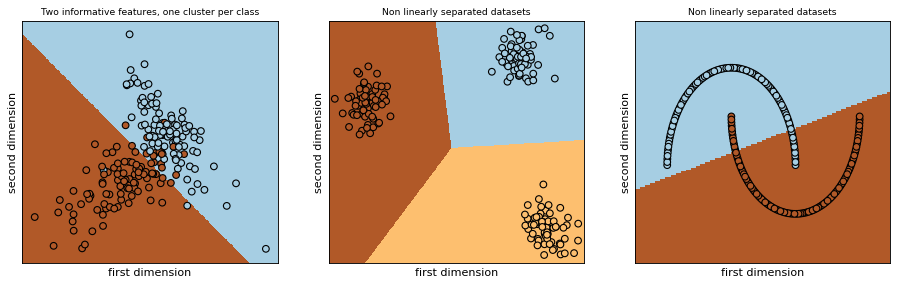

In [592]:
print("10-fold cross validation accuracies for the first simulated datasets :")
print(doKFold2(X1,Y1,10))


plt.figure(figsize=(14,4), dpi=80)
plt.subplot(131)
plt.title("Two informative features, one cluster per class", fontsize='small')
plot_grad_with_intercept(X1,Y1)
print("###")

print("10-fold cross validation accuracies for the second simulated datasets :")
print(doKFold2(X2,Y2,10))


plt.subplot(132)
plt.title("Non linearly separated datasets", fontsize='small')
plot_grad_with_intercept(X2,Y2)

print("10-fold cross validation accuracies for the third simulated datasets :")
print(doKFold2(X3,Y3,10))

plt.subplot(133)
plt.title("Non linearly separated datasets", fontsize='small')
plot_grad_with_intercept(X3,Y3)



plt.show()

## Test on cancer data

In [593]:
breast_data = pd.read_table(path + "BreastDiagnostic.txt", sep =",")
classes_breast = np.array([1 if label == "B" else 0 for label in breast_data.values[:,1]]).astype(float)
obs_breast = np.array(breast_data.values[:,2:]).astype(float)

mice_data = pd.ExcelFile(path + "Data_Cortex_Nuclear.xls")
mice_data = mice_data.parse()
mice_data.fillna(mice_data.median(), inplace=True)
obs_mice = np.array(mice_data.values[:,1:-4]).astype(float)
classes_mice = np.array([1 if label == "c-CS-m" else 0 for label in mice_data.values[:,-1]]).astype(float)


In [594]:
print(doKFold2(obs_breast,classes_breast,10))

[0.9122807  0.94736842 0.98245614 0.9122807  0.94736842 0.98245614
 1.         0.98245614 0.98214286 0.94642857]


In [595]:
for i in range(len(obs_mice[0])-1):
    for j in range(i+1,len(obs_mice[0])):
        if (obs_mice[:,i] == obs_mice[:,j]).all():
            print(i,j)

indices = [i for i in range(53)]
indices+= [i for i in range(54, len(obs_mice[0]))]

obs_mice = obs_mice[:,np.array(indices)]
print(doKFold2(obs_mice,classes_mice,10))


53 70
[0.01851852 0.76851852 0.90740741 0.61111111 1.         0.89814815
 0.90740741 0.9537037  1.         1.        ]
